In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [2]:
import os
os.getcwd()

'/Users/gzoeck/Desktop/ETH/DS Lab/dslab/code/whitness_based'

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [4]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                     #"wa-sa-A2", 
                                     #"wa-sa-B4",
                                     #"wa-sa-C4",
                                     #"wa-sa-B3",  
                                     #"wa-sa-B2",
                                     #"wa-sa-A5", 
                                     "po-di-se-1-A4",
                                     #"wa-sa-C2",
                                     "po-di-se-1-D4", # Pos
                                     #"wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-B1", 
                                     #"wa-sa-A4",
                                     #"wa-sa-A1", 
                                     #"wa-sa-D2",
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [5]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 3)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.ClusterHierarchyDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.9,
                                     eps=0.2,
                                     contamination=0.004,
                                     density_quantile=1,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_wa, verbose=1)

Time to remove Negatives: 0.0019829273223876953 seconds.
Time for Clustering: 1.1384670734405518 seconds.
Time for Whitening: 0.002087116241455078 seconds.
Time for Cluster Features: 0.07877302169799805 seconds.
Time for Predictions: 0.16362595558166504 seconds.
Time for Cluster Features (2): 7.152557373046875e-07 seconds.
Time to build Density estimation: 0.24768996238708496 seconds.
Time to compute point probabilies: 4.741093158721924 seconds.


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.004010771787085315, n_outlier: 210

Total error rate: 0.007169114233265082
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.00253     0.005733   0.012575   0.008242   0.005525  0.00841

Precision (TP / (TP + FP)): 0.9919115943899306
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999548      0.99375   0.973209   0.991082   0.998875 0.993209

Recall / TPR (TP / (TP + FN)): 0.999732422789843
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.999635   0.999388   0.999548   0.999902 0.999893

Specificity / TNR (TN / (TN + FP)): 0.9969824074374251
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999868     0.998117   0.991349   0.995925   0.999441 0.997319

Accuracy ((TP + TN) / (P + N)): 0.9977253496320472
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999898     0.998467   0.993272   0.997055   0.999594 0.998044

F1 (2 * (precision * r

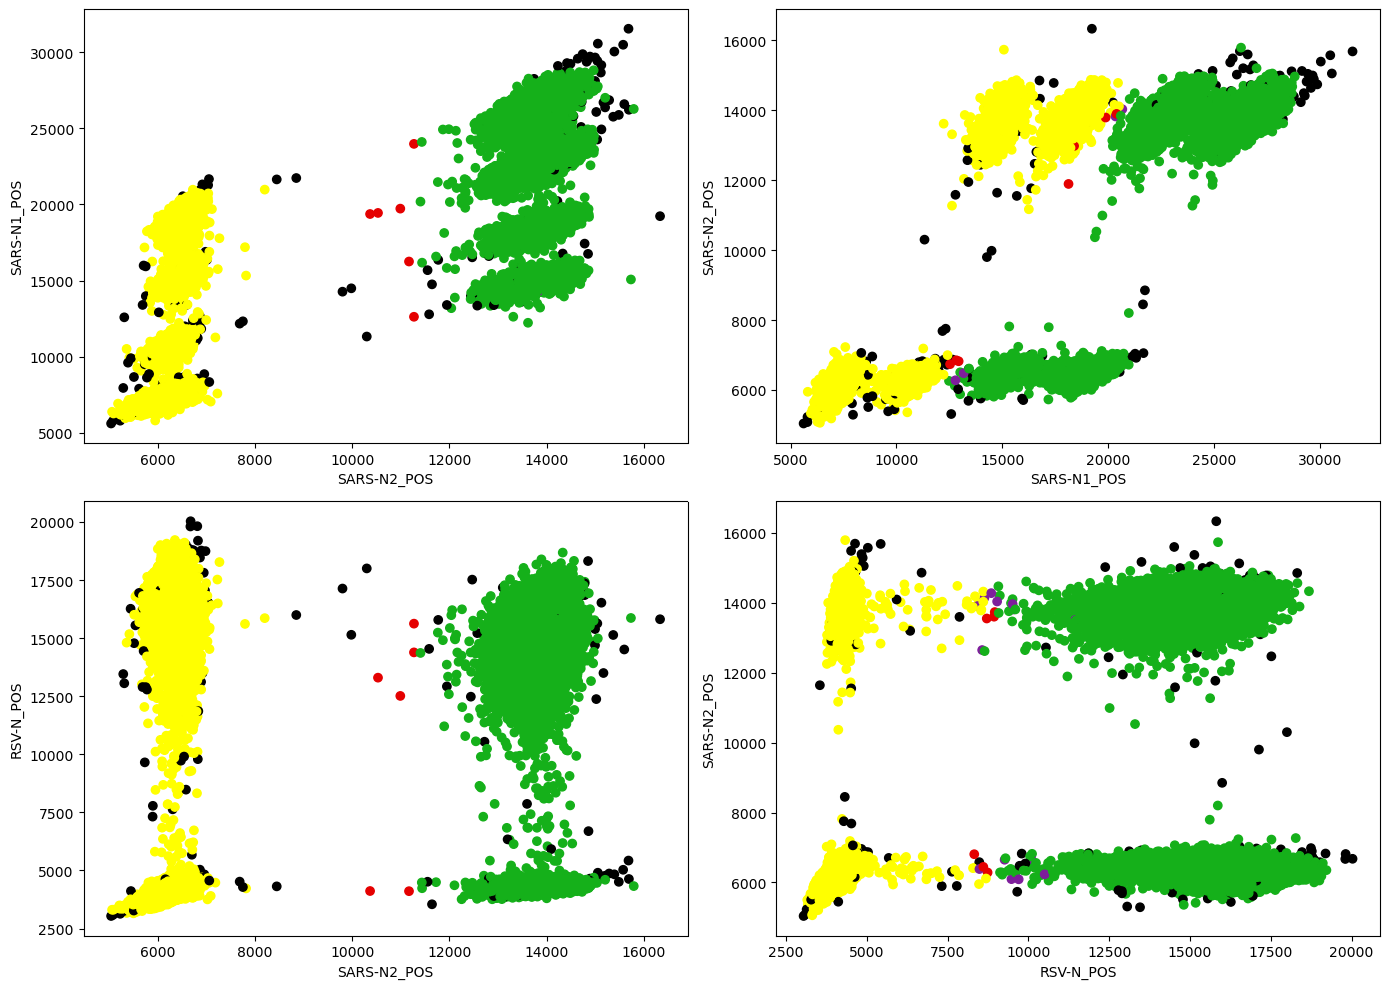

In [9]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('SARS-N2_POS','RSV-N_POS'),
                ('RSV-N_POS','SARS-N2_POS')#,
#                ('IAV-M_POS','MHV_POS'),
#                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, decision.probabilities_df, threshold=0.5)

df_result = stats_lib.compute_results(decision.probabilities_df, 0.01, 0.99, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        decision.predictions_df,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [8]:
df_result.to_csv("test_wa.csv")